In [2]:
#coding=utf-8
%matplotlib inline
import sys
sys.path.insert(0, '../')

from AircraftIden.StateSpaceIden import StateSpaceIdenSIMO, StateSpaceParamModel

from AircraftIden import FreqIdenSIMO, TransferFunctionFit
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import sympy as sp
pkl_name = "../../../FLYLOG/foam-tail-sitter/cruising/log_34_2018-4-10-freq-res-q.pkl"
finput = open(pkl_name, 'rb')
freq_responses = pickle.load(finput)
def plot_freqres_for_status(freqres , key = "-"):
    
    plt.figure("ele_body_vx")
    freqres.plt_bode_plot(0, label=key+"vx")
    plt.figure("ele_body_vz")
    freqres.plt_bode_plot(1, label=key+"vz")
    plt.figure("ele_body_ax")
    freqres.plt_bode_plot(2, label=key+"ax")
    plt.figure("ele_body_az")
    freqres.plt_bode_plot(3, label=key+"az")
    plt.show()

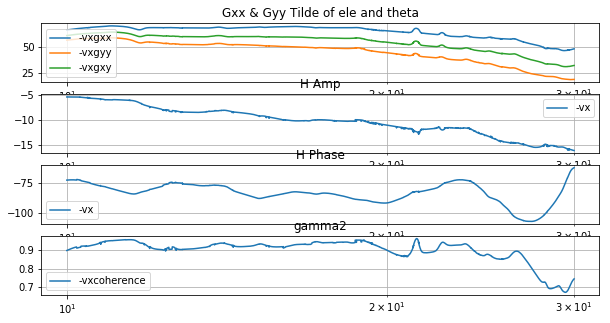

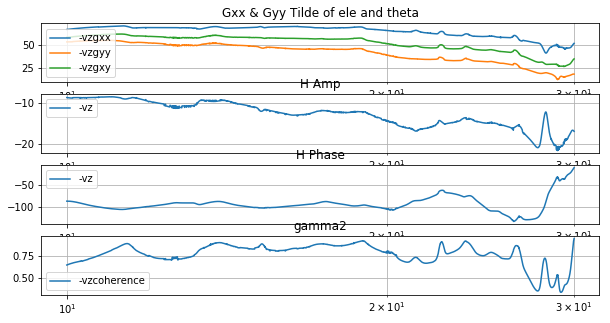

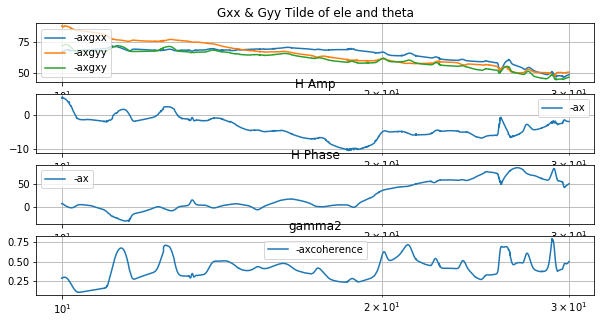

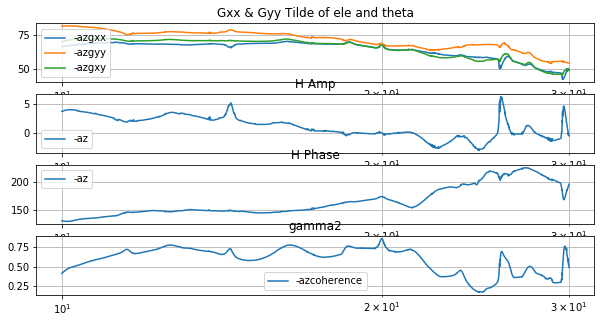

In [3]:
plt.rc('figure', figsize=(10.0, 5.0))
plt.close('all')
freqres_10ms = freq_responses["10m/s"]
plot_freqres_for_status(freqres_10ms)

In [4]:
# X = [u,w,th]
# Y = [u,w]

M = sp.Matrix([[1, 0, 0],
               [0, 1 , 0],
               [0, 0, 1]])

# Tailsittel
#    0---Vx, W
#--- | ----
# |  |  |
#    |
#  Vz ,-U
# 10m/s 

# Vz trim is -6.05,Vz is negative U
# Vx trim is 4.55, Vx is W
g = 9.78
#Th0 in multi mode is -0.95
th0 = 1.57 - 0.95

Xu, Xw, Xq = sp.symbols('Xu Xw Xq')
Zu, Zw, Zq = sp.symbols('Zu Zw Zq')
Mu, Mw, Mq = sp.symbols('Mu Mw Mq')


def process_ssm(freqres,trims):
    th0 = trims["theta"]
    F = sp.Matrix([[Xu, Xw, -g * math.cos(th0)],
               [Zu, Zw, -g * math.sin(th0)],
               [0, 0, 0]])
    G = sp.Matrix([[Xq],[Zq],[1]])
    # direct using -u w q for y
    #U equal to negative u
    H0 = sp.Matrix([
        [-1, 0, 0],
        [0, 1, 0]])
    H1 = sp.Matrix([
        [0, 0, 0],
        [0, 0, 0],
    ])
    syms = [Xu, Xw,Zu, Zw,Xq,Zq]
    LatdynSSPM = StateSpaceParamModel(M, F, G, H0, H1, syms)
    
    plt.rc('figure', figsize=(10.0, 5.0))
    freqres = freqres_10ms.get_freqres(indexs = [1,0])
    ssm_iden = StateSpaceIdenSIMO(freqres, accept_J=150,
                              enable_debug_plot=False,
                              y_names=['U',"w"],reg=0.0 )
    J, ssm = ssm_iden.estimate(LatdynSSPM, syms, constant_defines={})
    ssm.check_stable()
    ssm_iden.draw_freq_res()
    ssm_iden.print_res()

Process speed 5m/s
Will estimate num 6 [A_0_0, A_0_1, A_1_0, A_1_1, B_0_0, B_1_0]
Found new better 80.71453708758486
Eigs [-0.53054132+0.92351537j -0.53054132-0.92351537j  0.        +0.        j]
Stable
{Xu: 2.63413451684366, Xw: 2.82786456039581, Zu: -3.84320165861405, Zw: -3.69521714865649, Xq: -4.33370840384168, Zq: 5.53915469167695}
A
[[ 2.63413452  2.82786456 -4.52310689]
 [-3.84320166 -3.69521715 -8.67121122]
 [ 0.          0.          0.        ]]
B
[[-4.3337084 ]
 [ 5.53915469]
 [ 1.        ]]
Process speed 8m/s
Will estimate num 6 [A_0_0, A_0_1, A_1_0, A_1_1, B_0_0, B_1_0]
Found new better 80.65653880990389
Eigs [-0.78088505+1.19014012j -0.78088505-1.19014012j  0.        +0.        j]
Stable
{Xu: 2.25736883200535, Xw: 3.02928326989322, Zu: -3.51483145969505, Zw: -3.81913892904336, Xq: -4.34252459181909, Zq: 5.54542646179049}
A
[[ 2.25736883  3.02928327 -7.15591714]
 [-3.51483146 -3.81913893 -6.66642707]
 [ 0.          0.          0.        ]]
B
[[-4.34252459]
 [ 5.54542646]
 [

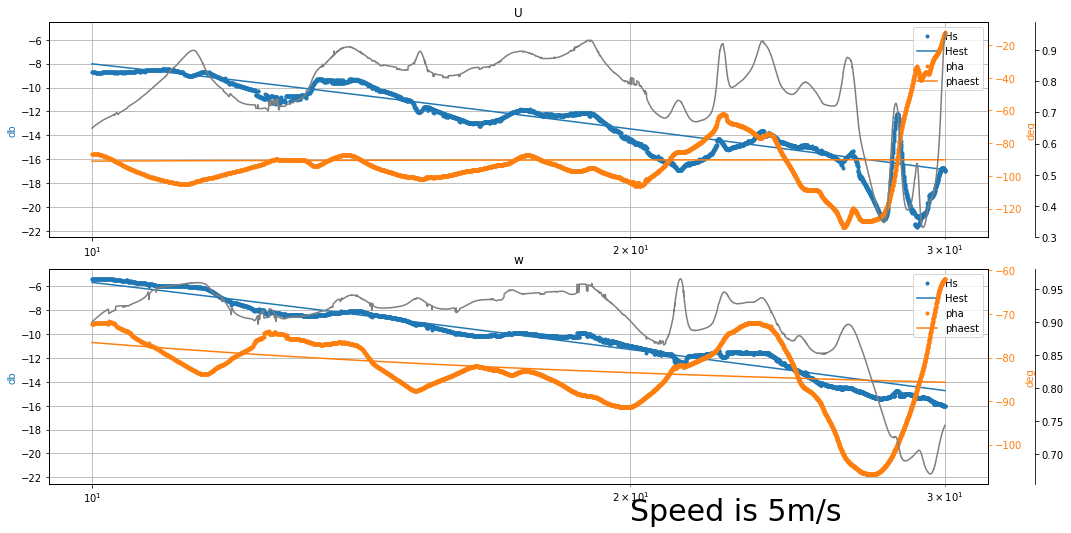

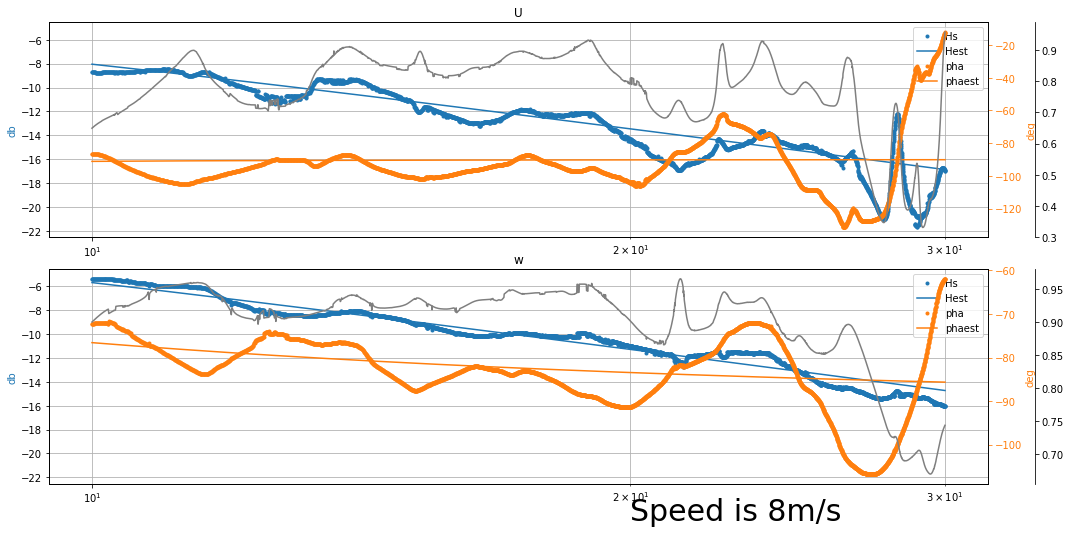

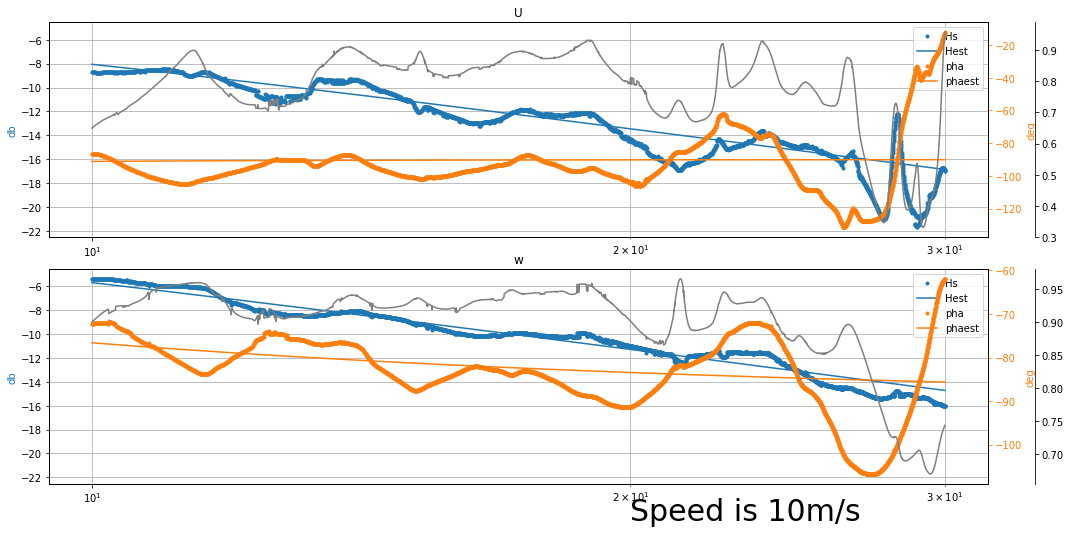

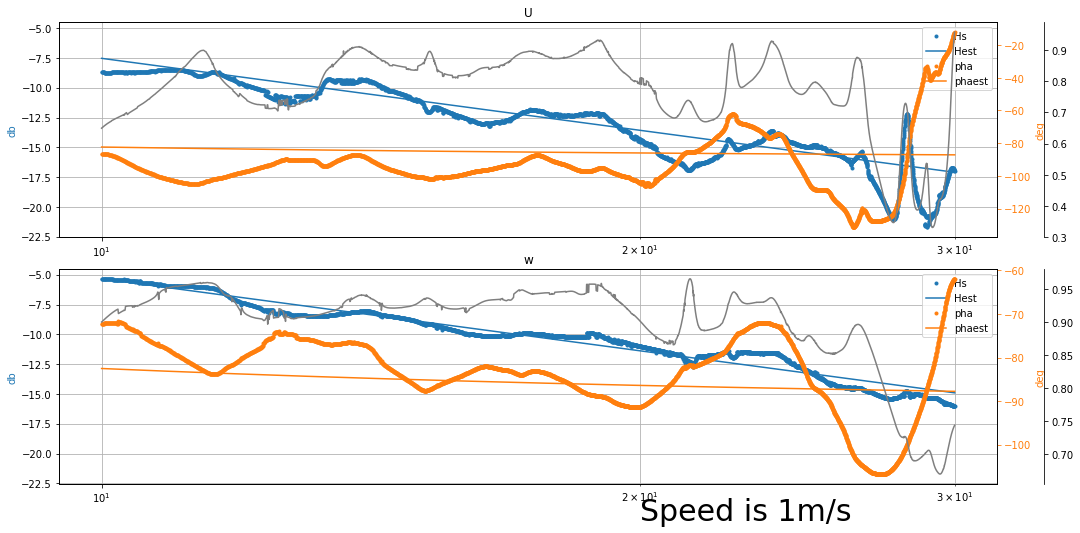

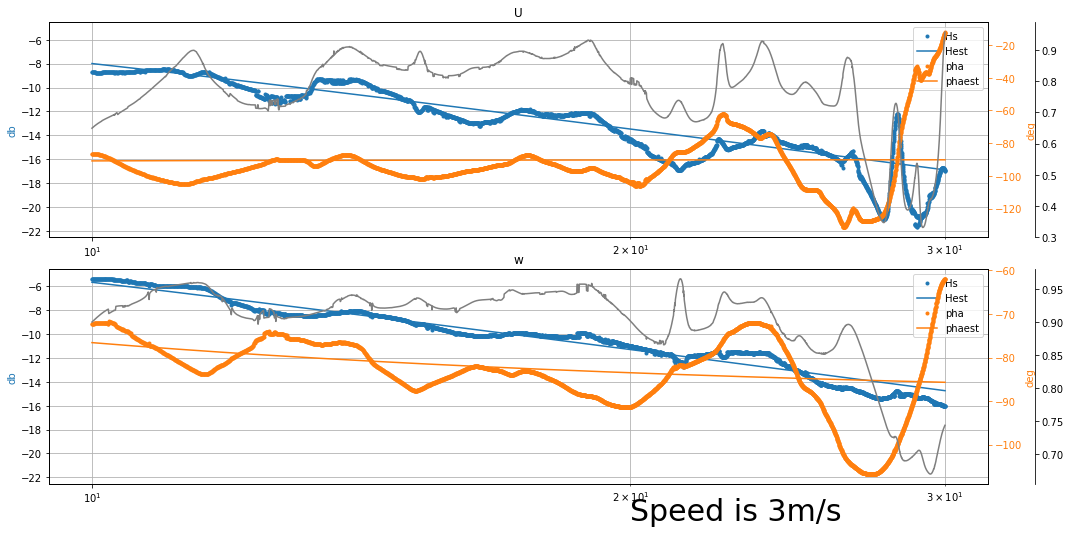

In [23]:
thetas = {
    "10m/s":-0.95,
    "8m/s":-0.82,
    "5m/s":-0.48,
    "3m/s":-0.26,
    "1m/s":-0.11
}
for key in freq_responses:
    print("Process speed {}".format(key))
    process_ssm(freq_responses[key],{"theta":1.57+thetas[key]})
    plt.text(20,0.6,"Speed is {}".format(key), fontsize=30)    